# RNN


### Import thư viện


In [4]:
# import thư viện
%pip install numpy pandas yfinance matplotlib scikit-learn tensorflow keras
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Tuple

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Bitcoin Dataset


### Import csv


In [5]:
# Đọc file Bitcoin
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Bitcoin Historical Data.csv"

data = pd.read_csv(file_path)

# Loại bỏ dấu phẩy và chuyển đổi thành float
for col in ['Price', 'Open']:
    data[col] = data[col].str.replace(',', '', regex=False).astype(float)

# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B'
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        return float(val)

data['Vol.'] = data['Vol.'].apply(convert_volume)

# Đổi Date sang datetime và đặt làm index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Select 3 columns: Price, Open, Vol
data_features = data[['Price', 'Open', 'Vol.']].copy()

print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst 5 rows:")
print(data[['Price', 'Open', 'Vol.']].head())
print(f"Tổng số dữ liệu: {len(data)} dòng")

Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  415.8  412.8  55740.0
2016-03-11  419.1  415.8  60630.0
2016-03-12  410.4  419.1  59640.0
2016-03-13  412.4  410.4  34980.0
2016-03-14  414.3  412.4  49330.0
Tổng số dữ liệu: 3370 dòng


### Chia 7:3


#### Chuẩn hóa dữ liệu


In [6]:
# Chuẩn hóa dữ liệu
# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [7]:
# Chia dữ liệu train/test theo tỷ lệ 7:3
train_size = int(len(data) * 0.7)
train_data = data.iloc[0:train_size,:]
test_data = data.iloc[train_size:len(data),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_data)}")
print(f"Kích thước tập test: {len(test_data)}")

Kích thước tập train: 2359
Kích thước tập test: 1011


#### Xây dựng mô hình RNN


In [8]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    Xây dựng mô hình RNN với regularization

    Args:
        time_step: Số time steps để nhìn về quá khứ
        num_features: Số features đầu vào (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer với regularization
    model.add(SimpleRNN(
        units=100,                       # Số neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Chỉ cần output cuối cùng
    ))

    # Dropout để tránh overfitting
    model.add(Dropout(0.3))

    # Dense layer ẩn
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: dự đoán 1 giá trị (Price)
    model.add(Dense(1))

    # Optimizer với learning rate nhỏ
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [9]:
# Hàm tạo dữ liệu time series với multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # Lấy tất cả features
        y_data.append(target_data[i + time_step, 0])     # Chỉ lấy Price
    return np.array(X_data), np.array(y_data)

In [10]:
# Hàm dự đoán với multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # Tạo input mới cho prediction tiếp theo
        # Giả sử các features khác không đổi, chỉ cập nhật Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # Cập nhật Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuyển đổi lst_output thành numpy array và inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Huấn luyện mô hình


In [11]:
# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình RNN
model_rnn = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

X_train shape: (2309, 50, 3)
y_train shape: (2309,)
X_test shape: (961, 50, 3)
y_test shape: (961,)


c:\Users\Hii\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0510 - mae: 0.1206 - val_loss: 0.0219 - val_mae: 0.0852 - learning_rate: 1.0000e-04
Epoch 2/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0510 - mae: 0.1206 - val_loss: 0.0219 - val_mae: 0.0852 - learning_rate: 1.0000e-04
Epoch 2/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0133 - mae: 0.0478 - val_loss: 0.0119 - val_mae: 0.0514 - learning_rate: 1.0000e-04
Epoch 3/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0133 - mae: 0.0478 - val_loss: 0.0119 - val_mae: 0.0514 - learning_rate: 1.0000e-04
Epoch 3/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0100 - mae: 0.0353 - val_loss: 0.0101 - val_mae: 0.0435 - learning_rate: 1.0000e-04
Epoch 4/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0100 - mae: 0.0353 - val_loss: 0.0101 - val_mae: 0.0435 - learning_rate: 1.0000e-04
Epoch 4/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0093 - mae: 0.0327 - val_loss: 0.0110 - val_mae: 0.0461

#### Đánh giá mô hình


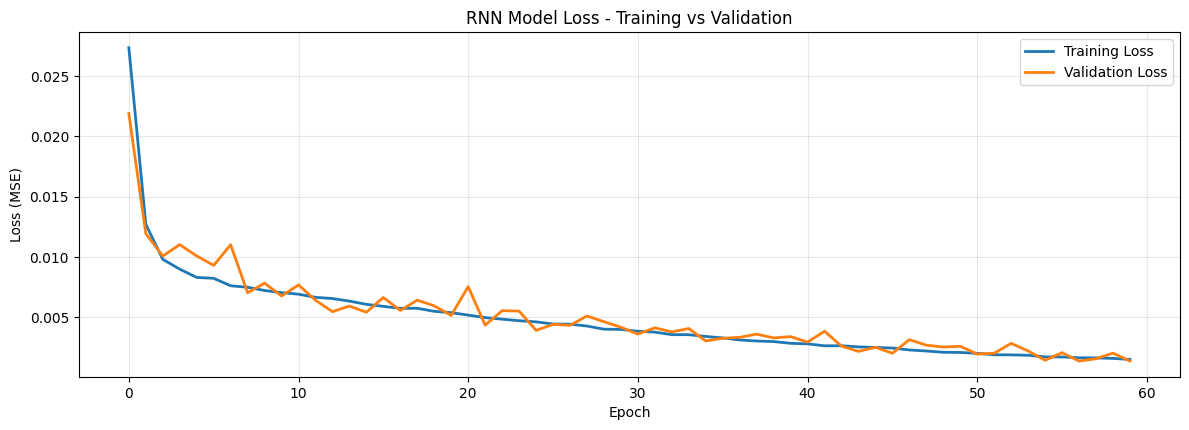

Epoch tốt nhất: 57 với val_loss: 0.001350


In [15]:
# Vẽ val_loss để đánh giá overfitting
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_rnn.history['val_loss']) + 1
best_val_loss = min(history_rnn.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

#### Dự đoán và trực quan hóa


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


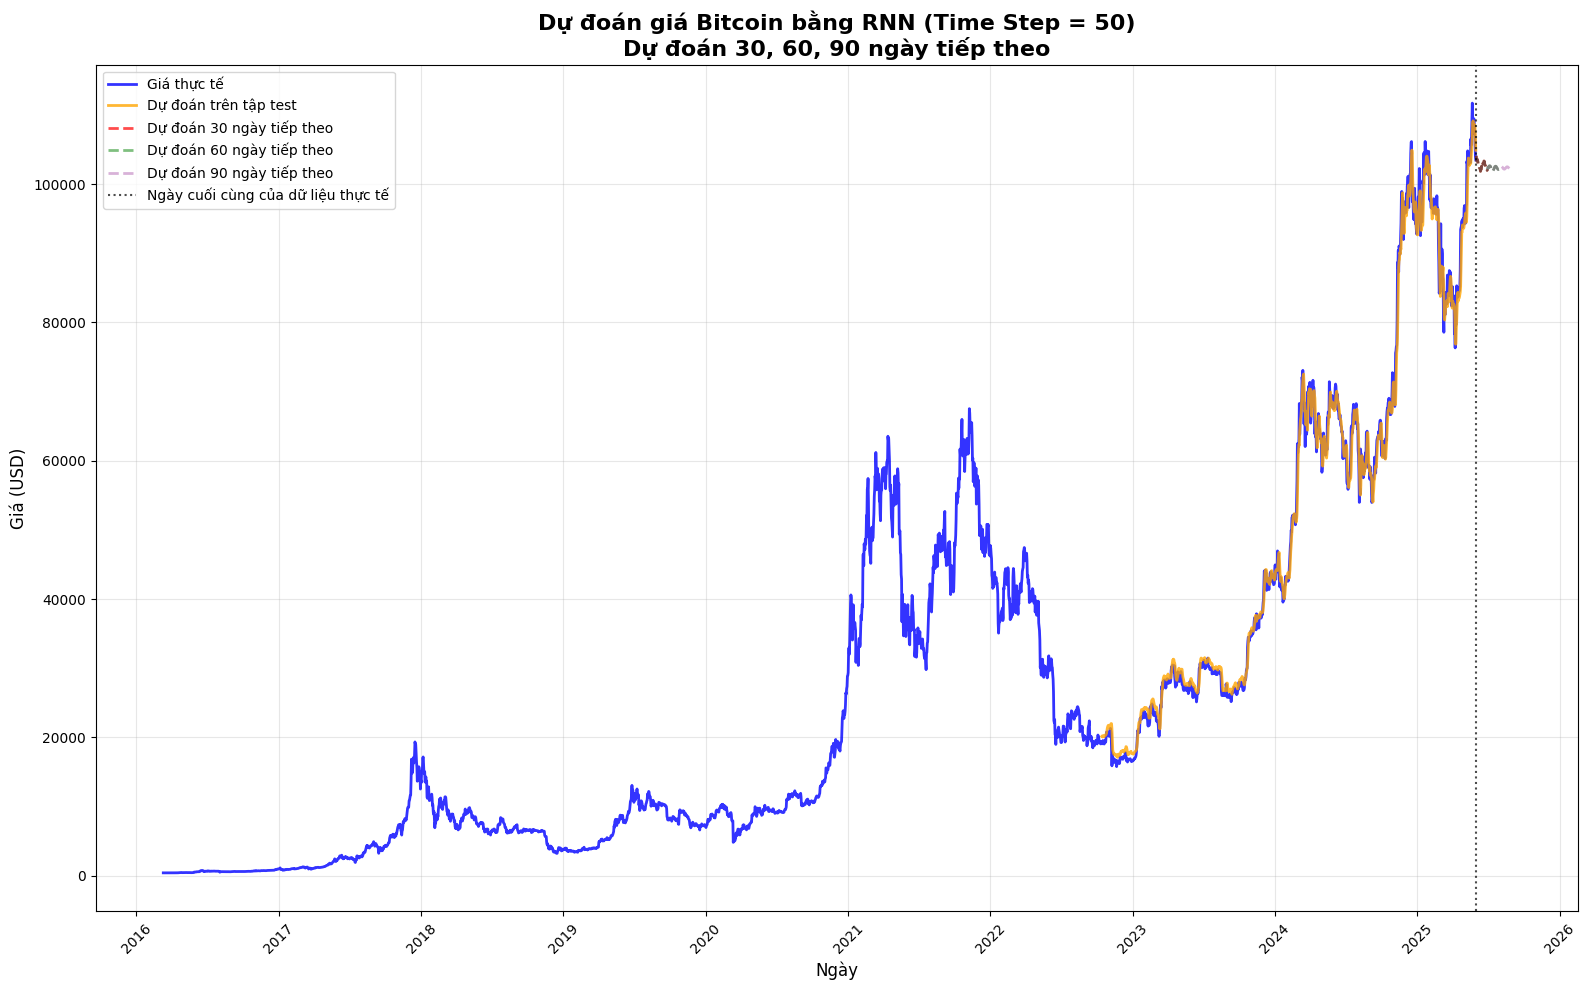

In [16]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

forecasted_prices_30 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
test_predict_scaled = model_rnn.predict(X_test)
test_predict_rnn = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(data.index, data['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_data.index[time_step:], test_predict_rnn,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng RNN (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Đánh giá mô hình
# Lấy giá trị thực tế trên tập test
y_test_actual = test_data['Price'].values[time_step:]

# Tính toán các metrics
mape = mean_absolute_percentage_error(y_test_actual, test_predict_rnn.flatten())
mse = mean_squared_error(y_test_actual, test_predict_rnn.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình RNN (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_rnn.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo:')
print(f'Giá cao nhất: ${forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: ${forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: ${forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình RNN (Time Step = 50):
MAPE: 0.03%
MSE: 3908918.20
RMSE: 1977.10
Số epochs huấn luyện: 60

Dự đoán giá Bitcoin 30 ngày tiếp theo:
Giá cao nhất: $104083.67
Giá thấp nhất: $101853.86
Giá trung bình: $102697.25


### Chia 8:2


#### Chuẩn hóa dữ liệu 8:2


In [ ]:
# Chuẩn hóa dữ liệu
# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [ ]:
# Chia dữ liệu train/test theo tỷ lệ 8:2
train_size_82 = int(len(data) * 0.8)
train_data_82 = data.iloc[0:train_size_82,:]
test_data_82 = data.iloc[train_size_82:len(data),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input_82 = scaled_input[0:train_size_82,:]
scaled_test_input_82 = scaled_input[train_size_82:,:]
scaled_train_target_82 = scaled_target[0:train_size_82,:]
scaled_test_target_82 = scaled_target[train_size_82:,:]

print(f"Kích thước tập train 8:2: {len(train_data_82)}")
print(f"Kích thước tập test 8:2: {len(test_data_82)}")

#### Xây dựng mô hình RNN


In [ ]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    Xây dựng mô hình RNN với regularization

    Args:
        time_step: Số time steps để nhìn về quá khứ
        num_features: Số features đầu vào (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer với regularization
    model.add(SimpleRNN(
        units=100,                       # Số neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Chỉ cần output cuối cùng
    ))

    # Dropout để tránh overfitting
    model.add(Dropout(0.3))

    # Dense layer ẩn
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: dự đoán 1 giá trị (Price)
    model.add(Dense(1))

    # Optimizer với learning rate nhỏ
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [ ]:
# Hàm tạo dữ liệu time series với multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # Lấy tất cả features
        y_data.append(target_data[i + time_step, 0])     # Chỉ lấy Price
    return np.array(X_data), np.array(y_data)

In [ ]:
# Hàm dự đoán với multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # Tạo input mới cho prediction tiếp theo
        # Giả sử các features khác không đổi, chỉ cập nhật Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # Cập nhật Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuyển đổi lst_output thành numpy array và inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Huấn luyện mô hình 8:2


In [ ]:
# Tạo dữ liệu train và test với time_step = 50 cho split 8:2
X_train_82, y_train_82 = create_multivariate_time_series_data(scaled_train_input_82, scaled_train_target_82, time_step)
X_test_82, y_test_82 = create_multivariate_time_series_data(scaled_test_input_82, scaled_test_target_82, time_step)

print(f"X_train_82 shape: {X_train_82.shape}")
print(f"y_train_82 shape: {y_train_82.shape}")
print(f"X_test_82 shape: {X_test_82.shape}")
print(f"y_test_82 shape: {y_test_82.shape}")

# Xây dựng mô hình RNN cho split 8:2
model_rnn_82 = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop_82 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr_82 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình 8:2
history_rnn_82 = model_rnn_82.fit(
    X_train_82, y_train_82,
    epochs=60,
    batch_size=16,
    validation_data=(X_test_82, y_test_82),
    callbacks=[early_stop_82, reduce_lr_82],
    verbose=1
)

#### Đánh giá mô hình 8:2


In [ ]:
# Vẽ val_loss để đánh giá overfitting cho split 8:2
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn_82.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn_82.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss 8:2 Split - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất cho split 8:2
best_epoch_82 = np.argmin(history_rnn_82.history['val_loss']) + 1
best_val_loss_82 = min(history_rnn_82.history['val_loss'])
print(f"Epoch tốt nhất (8:2): {best_epoch_82} với val_loss: {best_val_loss_82:.6f}")

#### Dự đoán và trực quan hóa 8:2


In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo cho split 8:2
last_data_scaled_82 = scaled_test_input_82[-time_step:]

forecasted_prices_30_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 30, scaler_target)
forecasted_prices_60_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 60, scaler_target)
forecasted_prices_90_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra cho split 8:2
test_predict_scaled_82 = model_rnn_82.predict(X_test_82)
test_predict_rnn_82 = scaler_target.inverse_transform(test_predict_scaled_82)

# Tạo DataFrame cho các dự đoán 8:2
forecast_dates_30_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30_82 = pd.DataFrame(forecasted_prices_30_82, index=forecast_dates_30_82, columns=['Price'])
forecast_df_60_82 = pd.DataFrame(forecasted_prices_60_82, index=forecast_dates_60_82, columns=['Price'])
forecast_df_90_82 = pd.DataFrame(forecasted_prices_90_82, index=forecast_dates_90_82, columns=['Price'])

# Trực quan hóa kết quả cho split 8:2
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(data.index, data['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test 8:2
plt.plot(test_data_82.index[time_step:], test_predict_rnn_82,
         label='Dự đoán trên tập test (8:2)', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai 8:2
plt.plot(forecast_df_30_82.index, forecast_df_30_82['Price'],
         label='Dự đoán 30 ngày tiếp theo (8:2)', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60_82.index, forecast_df_60_82['Price'],
         label='Dự đoán 60 ngày tiếp theo (8:2)', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90_82.index, forecast_df_90_82['Price'],
         label='Dự đoán 90 ngày tiếp theo (8:2)', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng RNN (8:2 Split, Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá mô hình 8:2
# Lấy giá trị thực tế trên tập test 8:2
y_test_actual_82 = test_data_82['Price'].values[time_step:]

# Tính toán các metrics cho split 8:2
mape_82 = mean_absolute_percentage_error(y_test_actual_82, test_predict_rnn_82.flatten())
mse_82 = mean_squared_error(y_test_actual_82, test_predict_rnn_82.flatten())
rmse_82 = np.sqrt(mse_82)

print(f'Kết quả đánh giá mô hình RNN 8:2 Split (Time Step = {time_step}):')
print(f'MAPE: {mape_82:.2f}%')
print(f'MSE: {mse_82:.2f}')
print(f'RMSE: {rmse_82:.2f}')
print(f'Số epochs huấn luyện: {len(history_rnn_82.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày cho 8:2
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo (8:2):')
print(f'Giá cao nhất: ${forecasted_prices_30_82.max():.2f}')
print(f'Giá thấp nhất: ${forecasted_prices_30_82.min():.2f}')
print(f'Giá trung bình: ${forecasted_prices_30_82.mean():.2f}')